# Convolutional neural networks for genetic sequences

By Ziga Avsec

This exercise will walk you through an end-to-end example on how to train a basic convolutional neural network for genomic sequences.

The steps you are going to take will be:
- download a simulated dataset of DNA sequences corresponding either to the positive or the negative class
- build a classifier based on convolutional neural networks to distinguish these two classes of sequences
- evaluate the model
- visualize the filters of the first convolutional layer
- visualize feature importance score using saliency maps

After this example, you will be ready to apply these networks in a real-world application - namely to replicate the performance of the DeepBind model: https://www.nature.com/articles/nbt.3300.

## Install the dependencies

In addition to the pre-installed packages like numpy, pandas, matplotlib, keras, tensorflow, we'll install concise, a keras extension for regulatory genomics developed in the Gagneur lab: https://github.com/gagneurlab/concise.

In [1]:
!pip install concise

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Get the data

We are going to use simulated data of 10,000 500 bp long sequences with the positive set containing an instance of the TAL1 motif:
![TAL1 known4](http://compbio.mit.edu/encode-motifs/logos/table/logos/small/rev/TAL1_known4.png)
and the negative set will be random sequences. The data were simulated using simDNA https://github.com/kundajelab/simdna by Johnny Israeli and were deposited to https://github.com/kundajelab/dragonn.

In [2]:
!wget 'https://github.com/kundajelab/dragonn/raw/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz'

--2018-12-11 19:46:17--  https://github.com/kundajelab/dragonn/raw/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz
Resolving github.com (github.com)... 192.30.255.112, 192.30.255.113
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kundajelab/dragonn/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz [following]
--2018-12-11 19:46:18--  https://raw.githubusercontent.com/kundajelab/dragonn/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.188.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.188.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

## Load the data

The following function can load the data.

In [3]:
import numpy as np

def load_simulated_data(path):
    """Load the simulated dataset
    
    Args:
      path: path to the .npz file c
    """
    data = np.load(path)

    x_train = data["X_train"].squeeze(1).swapaxes(1,2)
    x_valid = data["X_valid"].squeeze(1).swapaxes(1,2)
    y_train = data['y_train']
    y_valid = data['y_valid']
    return (x_train, y_train), (x_valid, y_valid)

We now list all files in our directory

In [4]:
ls

build/
Copy_of_Simulated.ipynb
dist/
docker/
Dockerfile
dragonn/
dragonn.egg-info/
examples/
GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz
LICENSE
paper_supplement/
pytest.ini
README.md
scripts/
setup.py
tests/


and load the first file. The data is splitted into training dataset, on wchih the model will be fitted, and a test dataset on which its performance will be assessed.

In [5]:
(x_train, y_train), (x_test, y_test) = load_simulated_data("GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz")

In [6]:
x_train.shape

(12800, 500, 4)

In [7]:
y_train.shape

(12800, 1)

In [8]:
x_test.shape

(3200, 500, 4)

In [9]:
y_test.shape

(3200, 1)

As you can see, there are 12.8k training examples and 3.2k test examples.

### Visualize the first sequence

The response value is a binary variable:

In [10]:
y_train[:5]

array([[False],
       [False],
       [ True],
       [ True],
       [ True]])

In [11]:
y_train.mean()

0.501953125

In [12]:
y_test.mean()

0.5071875

As the means are close to 0.5, there are balanced classes, i.e. roughly the same number of positive and negative instances. This ratio is the same for training and testing. This is an ideal situation for training a classifier. 

The input is the one-hot-encoded DNA sequence:

In [13]:
x_train[0][:10]

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]], dtype=int8)

Which can be easily converted back to a string:

In [14]:
from concise.preprocessing.sequence import one_hot2string, DNA

Using TensorFlow backend.


In [15]:
one_hot2string(x_train[:1], DNA)[0]

'CGTTATGAGTCATGACTGTTATTTTTACCCAAAACAGTGTCTAGCCAAAAATATTGATGCAGTGTTTTCATCAGATTCAATTTCCAACGAAAAGACTCGCGTTCCTTAACTGCAAATTAGCGTAATTCTCACTTGCATATCAAGAGTTCTGTACTAAGATCAAACTCAAGTTATTTTAAGGGATACATTTATATAATAACACCCATGAGCCTGAGAAGGTAAGAATCTGACACTAATGATATGCGGTAGCTATTCACTACAGCAATTTAACCTCGAAGGAAAATCCCTTCAACTCACATCTTTTCATGTTATTGCTTTCTGTGATGGCTATGTTTCCGGAATCAGGAAATCGTCTCCTCACTTTCGTGGAGATACATGAACTGGATACGACAAGCGTTGTTATCTCCGATGCCTCAGGCGTGTGCATAATAGCACCGTATTAATTTCTTCAGTATAGTCCAACATGTTTCCGTTGTAGAACCAAAGCGGCTTTTAGATTA'

## 101 in Convolutional neural networks for DNA sequences

The following code will give you an end-to-end example for training, evaluating and visualizing convolutional neural networks for DNA sequence models.

### Define the model

We'll use Keras (https://keras.io), a popular deep learning library wrapping frameworks like TensorFlow to define and train a neural network. After running the code, go to the documentation and read more about Keras.

In [16]:
from keras.models import Sequential
import keras.layers as kl
from keras.callbacks import EarlyStopping, History

We will now implement a neural network (sketch below) consisting of 16 convolutional filters whose outputs are  transfomed by the ReLU activation function ($\text{ReLU}(x) = \max(0,x)$) . On each of the 16 vectors, we keep the maximal value ("max pooling") giving a us 16-long vector. We then perform a linear transformation of this 16-long vector into a single scalar ("Dense layer") which we map to the $[0,1]$ interval with sigmoid activation function $\text{sigm}(x) = \frac{1}{1+\exp(-x)} $ . The interpratation of the output is the probability that the sequence is bound by the transcription factor TAL1.

In [17]:
# Define model architecture
# It can be simpy define as a sequence of layers using keras.models.Sequential
model = Sequential([kl.Conv1D(filters=16, kernel_size=15, activation='relu', input_shape=x_train.shape[1:]),
                    kl.GlobalMaxPooling1D(),
                    kl.Dense(units=1),
                    kl.Activation('sigmoid')
                   ])

In [18]:
# Compile the model. We need to specify:
# - which optimizer do we use, what is the loss function and what additional metrics we want to use.
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [19]:
# Visualize model layers
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 486, 16)           976       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [20]:
# Making sure our results are reproducible
# The model is namely initialized using random weights
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [21]:
# Train the model
history = model.fit(x_train, 
                    y_train, 
                    validation_split=0.2,  # use 20% of the data as the validation set
                    callbacks=[EarlyStopping(patience=3),   # If val_loss doesn't decrease after 3 epochs, stop training
                               History()],
                    batch_size=512,  # On every optimization step, we use 512 examples from the training data
                    epochs=100)  # 1 epoch = one full pass through the data

Train on 10240 samples, validate on 2560 samples
Epoch 1/100
10240/10240 [==============================] - 20s 2ms/step - loss: 0.7068 - acc: 0.5008 - val_loss: 0.7024 - val_acc: 0.4957
Epoch 2/100
10240/10240 [==============================] - 0s 23us/step - loss: 0.6948 - acc: 0.5114 - val_loss: 0.6951 - val_acc: 0.5012
Epoch 3/100
10240/10240 [==============================] - 0s 20us/step - loss: 0.6921 - acc: 0.5184 - val_loss: 0.6949 - val_acc: 0.4918
Epoch 4/100
10240/10240 [==============================] - 0s 22us/step - loss: 0.6908 - acc: 0.5310 - val_loss: 0.6940 - val_acc: 0.5035
Epoch 5/100
10240/10240 [==============================] - 0s 22us/step - loss: 0.6896 - acc: 0.5369 - val_loss: 0.6930 - val_acc: 0.5035
Epoch 6/100
10240/10240 [==============================] - 0s 23us/step - loss: 0.6871 - acc: 0.5582 - val_loss: 0.6909 - val_acc: 0.5227
Epoch 7/100
10240/10240 [==============================] - 0s 25us/step - loss: 0.6832 - acc: 0.5824 - val_loss: 0.6872 - v

10240/10240 [==============================] - 0s 24us/step - loss: 0.1732 - acc: 0.9558 - val_loss: 0.1973 - val_acc: 0.9484
Epoch 60/100
10240/10240 [==============================] - 0s 23us/step - loss: 0.1712 - acc: 0.9572 - val_loss: 0.1958 - val_acc: 0.9496
Epoch 61/100
10240/10240 [==============================] - 0s 24us/step - loss: 0.1693 - acc: 0.9572 - val_loss: 0.1943 - val_acc: 0.9480
Epoch 62/100
10240/10240 [==============================] - 0s 25us/step - loss: 0.1673 - acc: 0.9569 - val_loss: 0.1928 - val_acc: 0.9500
Epoch 63/100
10240/10240 [==============================] - 0s 22us/step - loss: 0.1657 - acc: 0.9576 - val_loss: 0.1916 - val_acc: 0.9496
Epoch 64/100
10240/10240 [==============================] - 0s 22us/step - loss: 0.1642 - acc: 0.9582 - val_loss: 0.1900 - val_acc: 0.9496
Epoch 65/100
10240/10240 [==============================] - 0s 23us/step - loss: 0.1622 - acc: 0.9591 - val_loss: 0.1888 - val_acc: 0.9484
Epoch 66/100
10240/10240 [==============

### Evaluate the model

Once the model has been trained, one should evaluate the model on the held-out test set using different metrics.

In [0]:
from concise.eval_metrics import auc, auprc

def evaluate(model, x, y, add_metrics={}):
    """Evaluate model performance
    
    Args:
      model: Keras model
      x: model inputs
      y: model targets
      add_metrics: additional metrics
      
    Returns:
      A dictionary of type: <metric>: <value>
    """
    keras_metrics = {name: metric 
                     for name, metric in zip(model.metrics_names, 
                                             model.evaluate(x, y, verbose=0))}
    y_pred = model.predict(x)
    add_metrics= {k: v(y, y_pred) for k,v in add_metrics.items()}
    return {**keras_metrics, **add_metrics}

In [0]:
evaluate(model, x_test, y_test, add_metrics={'auROC': auc, "auPRC": auprc})

{'acc': 0.9478125,
 'auPRC': 0.9603978714574579,
 'auROC': 0.9726310632157973,
 'loss': 0.1798541477508843}

### Question 1

What are those metrics representing?

### Visualize the training history

As the model sees more and more data, it becomes more accurate on the training set and also on the validation set.

In [0]:
def plot_history(history, figsize=(8, 5)):
    """Plot metric values through training
    
    Args:
      history: object returned by model.fit(, callbacks=[History(), ...])
      metric: metric name from model.metrics_names
    """
    # Setup the figure object
    figsize=(figsize[0]*len(model.metrics_names), figsize[1])
    fig = plt.figure(figsize=figsize)
    
    for i, metric in enumerate(model.metrics_names):
        plt.subplot(1, len(model.metrics_names), i+1)
        
        plt.plot(history.epoch, history.history[metric], label=f'train')
        plt.plot(history.epoch, history.history['val_'+metric], label=f'valid')
        
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel(metric)
        plt.title(metric)
        
    plt.tight_layout()

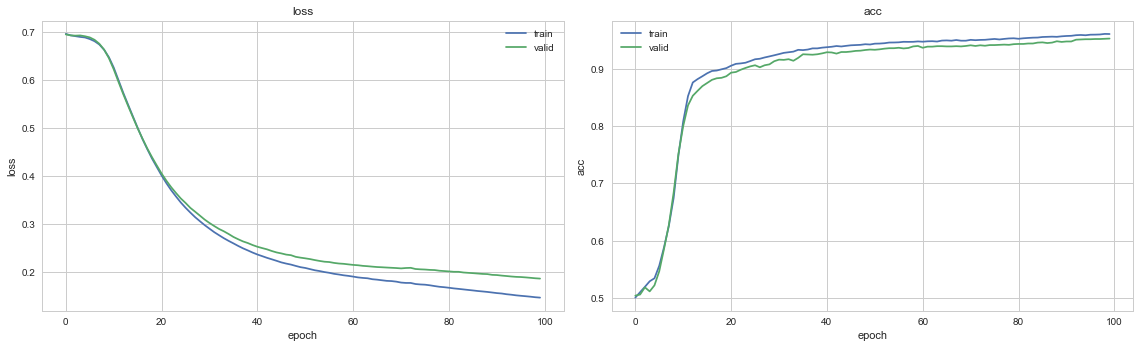

In [0]:
plot_history(history, figsize=(8, 5))

### Question

Why is the training accuracy higher? Why do we use early stopping?

## Visualizing the learned parameters

What did the model learn? Let's have a look at the model paramters.

### Dense layer

In [0]:
W_dense, b_dense = model.layers[-2].get_weights()

In [0]:
b_dense

array([-0.1324], dtype=float32)

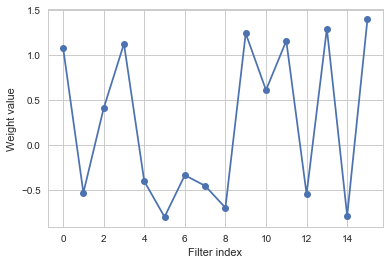

In [0]:
plt.plot(W_dense, "-o")
plt.xlabel("Filter index")
plt.ylabel("Weight value");

### Convolutional layer

In [0]:
from concise.utils.pwm import DEFAULT_BASE_BACKGROUND, pssm_array2pwm_array, _pwm2pwm_info
from concise.utils.plot import seqlogo, seqlogo_fig


def plot_filters(W, ncol=2, figsize=(10,10)):
    """Plot convolutional filters as motifs
    
    Args:
      weights: weights returned by `model.layers[0].get_weights()[0]`
      ncol: number of columns in the plot
      figsize: Matplotlib figure size (width, height)
    """
    N = W.shape[2]
    nrow = int(np.ceil(N/ncol))
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    for i in range(N):
        ax = fig.axes[i]
        seqlogo(W[:,:,i], ax=ax);
        ax.set_title(f"Filter: {i}")
    plt.tight_layout()

In [0]:
W_conv, b_conv = model.layers[0].get_weights()

In [0]:
W_conv.shape

(15, 4, 16)

In [0]:
b_conv.shape

(16,)

In [0]:
W_conv, b_conv = model.layers[0].get_weights()

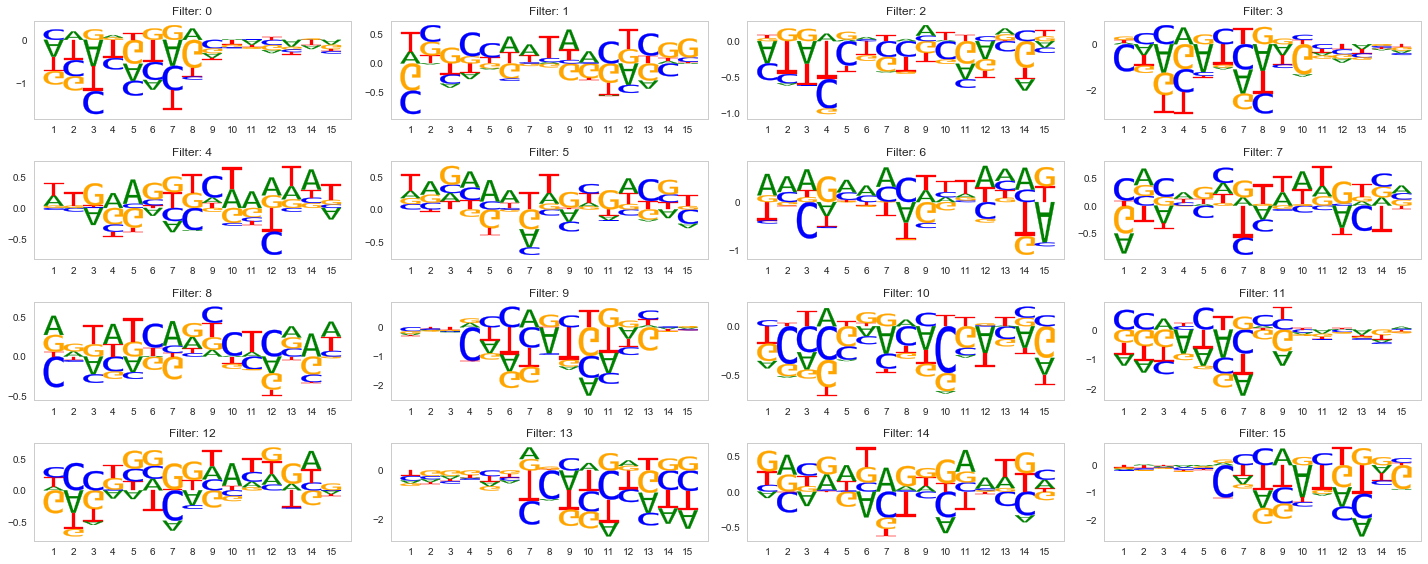

In [0]:
plot_filters(W_conv, 4, figsize=(20,8))

Last filter has the largest weight and kind-of resembles the cannonical motif:
![TAL1 known4](http://compbio.mit.edu/encode-motifs/logos/table/logos/small/rev/TAL1_known4.png)

As you can see, the filters/model parameters are difficult to be interepreted directly. However, there are alternative approaches of interepreting sequences.

## Interpreting individual examples

Given that you see this sequence:

In [0]:
one_hot2string(x_test[:1], DNA)[0]

'ATTTACATGATATCACACACGATTGTAGCCTGACCACAATGAGTGATAGGGACGTAGCTCTTGTAACTTCAGGAGTTTTTATGGGCACTAATTAAATTGAATTATAGTTATCAAGCTAGAAAGAGATTGTAGTACCTCAACGCTAGAAGATTTGGTCCTCTACGTAAAAAGTTACACGTTGCATAAACGTAACCATACTCCGTTCCGAATAAACGAATTGGTTACATTAGCTGCAATTGGAATACTCTACAATAAGATAGACTACTAAGGCCTAGTACCGAGGTCTTAGGACTTCACCGGTACCTATCACAGCAGATGGCAGCGCCATCATGTTAGGGCACATGTGATGCTCCCTGTAACATATTTTTGGACAATCCAACTATCTGCAGAATTTTTCTCCAAGAATTGTATTCTATGGTTAACGAAATAATGATTCTTCCGTAGCACTGGGCTATTTTAGCTAATAAGGGTACGATAGGGTACGAATACTTCATATTGAA'

Can you tell why is the model predicting a positive class? Which subpart of the sequence is driving the model prediction?

Consider a neural net being a function: $f(x_1, ..., x_N; w) = y$

One way to tell whether the input feature is important is to compute the gradient of the function with respect to (w.r.t.) model input: $\frac{\partial f}{\partial x_i}$

This approach is called saliency maps: "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", by Karen Simonyan, Andrea Vedaldi and Andrew Zisserma https://arxiv.org/pdf/1312.6034.pdf

In genomics, we typically visualize only gradients for bases observed in the sequence (called input masked gradients or input*grad).

### Input*gradient feature importance scores

In [0]:
import keras.backend as K


def input_grad(model, x, layer_idx=-2):
    """Get the gradient of model output (before the final activation layer) w.r.t. model input
    
    Args:
      model: Sequence-based keras model
      x: one-hot-encoded DNA sequence
      layer_idx: output layer index
    """
    fn = K.function([model.input], K.gradients(model.layers[layer_idx].output, [model.input]))
    return fn([x])[0]


def plot_seq_importance(model, x, xlim=None, layer_idx=-2, figsize=(25, 3)):
    """Plot input x gradient sequence importance score
    
    Args:
      model: DNA-sequence based Sequential keras model
      x: one-hot encoded DNA sequence
      xlim: restrict the plotted xrange
      figsize: matplotlib figure size
    """
    seq_len = x.shape[1]
    if xlim is None:
        xlim = (0, seq_len)
    grads = input_grad(model, x, layer_idx=layer_idx)
    for i in range(len(x)):
        seqlogo_fig(grads[i]*x[i], figsize=figsize)
        plt.xticks(list(range(xlim[0], xlim[1], 5)))
        plt.xlim(xlim)

Here is the answer to the previous question on what is important in this sequence:

```
ATTTACATGATATCACACACGATTGTAGCCTGACCACAATGAGTGATAGGGACGTAGCTCTTGTAACTTCAGGAGTTTTTATGGGCACTAATTAAATTGAATTATAGTTATCAAGCTAGAAAGAGATTGTAGTACCTCAACGCTAGAAGATTTGGTCCTCTACGTAAAAAGTTACACGTTGCATAAACGTAACCATACTCCGTTCCGAATAAACGAATTGGTTACATTAGCTGCAATTGGAATACTCTACAATAAGATAGACTACTAAGGCCTAGTACCGAGGTCTTAGGACTTCACCGGTACCTATCACAGCAGATGGCAGCGCCATCATGTTAGGGCACATGTGATGCTCCCTGTAACATATTTTTGGACAATCCAACTATCTGCAGAATTTTTCTCCAAGAATTGTATTCTATGGTTAACGAAATAATGATTCTTCCGTAGCACTGGGCTATTTTAGCTAATAAGGGTACGATAGGGTACGAATACTTCATATTGAA
```

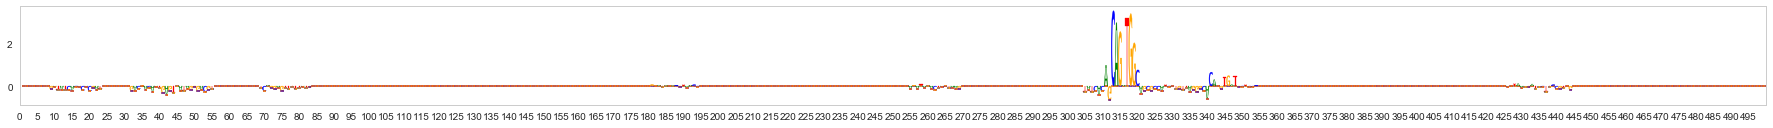

In [0]:
plot_seq_importance(model, x_test[:1], figsize=(25, 2))

 As you can see, there is single sequence that really pops ups. Let's have a closer look

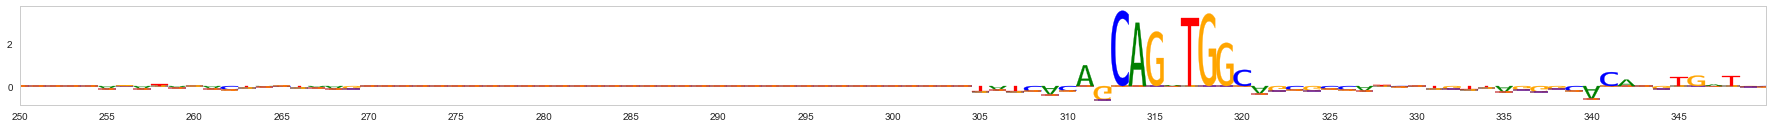

In [0]:
plot_seq_importance(model, x_test[:1], xlim=(250, 350), figsize=(25, 2))

As you can see, the cannonical TAL1 motif used to simulate the data shows up:
![TAL1 known4](http://compbio.mit.edu/encode-motifs/logos/table/logos/small/rev/TAL1_known4.png)

Let's have a look at some more examples

In [0]:
seq_pos = x_test[y_test[:,0]==1]
seq_neg = x_test[y_test[:,0]==0]

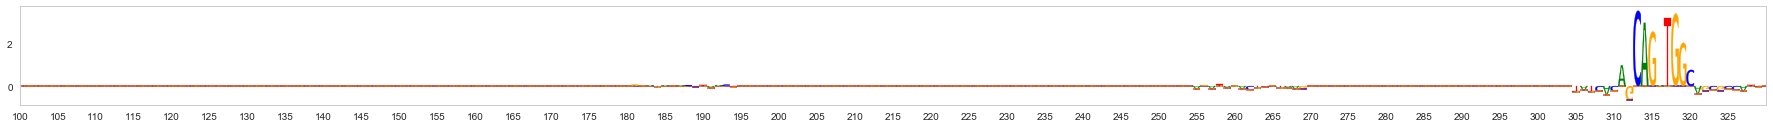

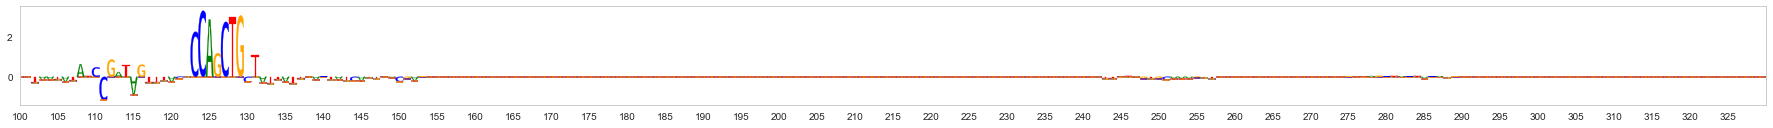

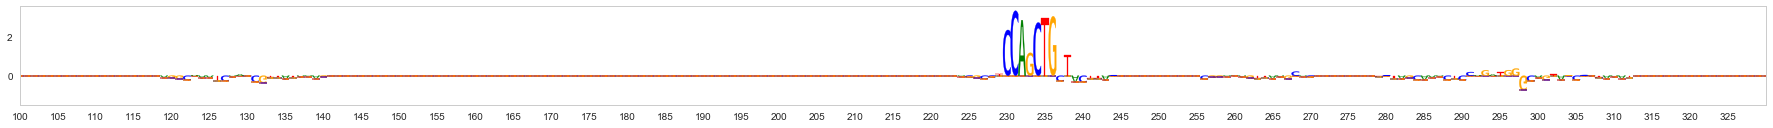

In [0]:
plot_seq_importance(model, seq_pos[:3], xlim=(100, 330), figsize=(25, 2))

As you can see, the CCANCTG motif clearly pops up. How does it look for the negative sequences?

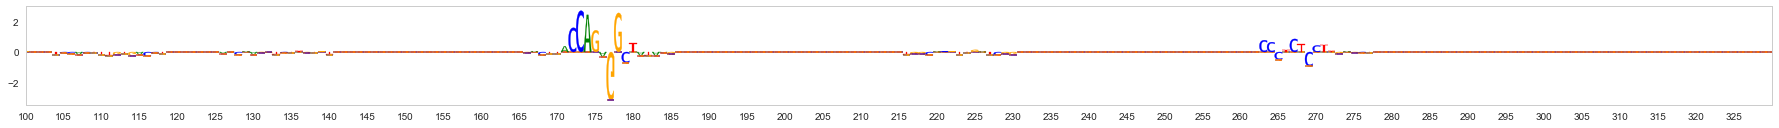

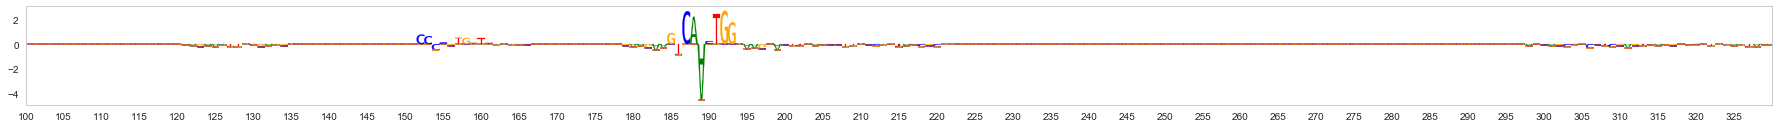

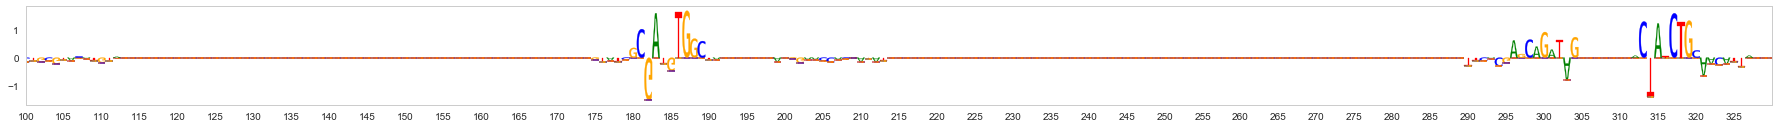

In [0]:
plot_seq_importance(model, seq_neg[:3], xlim=(100, 330), figsize=(25, 2))

There doesn't seem to be as strong as for the positive examples.

### Questions

- Try fitting a model using only a single filter and using more filters (e.g. 128). What do you observe?